In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc, os



from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

In [2]:
#Feature Selection

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns

In [3]:
## Import all quarter data
q1_2017 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2017_Q1.csv')
q2_2017 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2017_Q2.csv')
q3_2017 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2017_Q3.csv')
q4_2017 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2017_Q4.csv')

q1_2018 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2018_Q1.csv')
q2_2018 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2018_Q2.csv')
q3_2018 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2018_Q3.csv')
q4_2018 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2018_Q4.csv')

q1_2019 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2019_Q1.csv')
q2_2019 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2019_Q2.csv')
q3_2019 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2019_Q3.csv')
q4_2019 = pd.read_csv('C:/DPA Project/data/Divvy_Trips_2019_Q4.csv')


In [4]:
#Station Data

station_data = pd.read_csv("C:/DPA Project/data/Divvy_Bicycle_Stations.csv")
station_data.head()

,ID,Station Name,Total Docks,Docks in Service,Status,Latitude,Longitude,Location
0,675,HQ QR,7,7,In Service,41.889914,-87.680343,"(41.88991358344108, -87.68034316599368)"
1,418,Ellis Ave & 53rd St,11,11,In Service,41.799336,-87.600958,"(41.79933626261, -87.6009581145)"
2,249,Montrose Harbor,31,31,In Service,41.963982,-87.638181,"(41.963982, -87.638181)"
3,322,Kimbark Ave & 53rd St,19,19,In Service,41.799568,-87.594747,"(41.799568, -87.594747)"
4,168,Michigan Ave & 14th St,19,19,In Service,41.864059,-87.623727,"(41.864059, -87.623727)"


In [5]:
## Rename q1_2018 & q2_2019 columns to match others
q1_2018.rename(columns={'01 - Rental Details Rental ID':'trip_id', '01 - Rental Details Local Start Time':'start_time','01 - Rental Details Local End Time':'end_time','01 - Rental Details Bike ID':'bikeid','01 - Rental Details Duration In Seconds Uncapped':'tripduration','03 - Rental Start Station ID':'from_station_id', '03 - Rental Start Station Name':'from_station_name','02 - Rental End Station ID':'to_station_id','02 - Rental End Station Name':'to_station_name', 'User Type':'usertype', 'Member Gender':'gender','05 - Member Details Member Birthday Year':'birthyear'}, inplace=True)

q2_2019.rename(columns={'01 - Rental Details Rental ID':'trip_id', '01 - Rental Details Local Start Time':'start_time','01 - Rental Details Local End Time':'end_time','01 - Rental Details Bike ID':'bikeid','01 - Rental Details Duration In Seconds Uncapped':'tripduration','03 - Rental Start Station ID':'from_station_id', '03 - Rental Start Station Name':'from_station_name','02 - Rental End Station ID':'to_station_id','02 - Rental End Station Name':'to_station_name', 'User Type':'usertype', 'Member Gender':'gender','05 - Member Details Member Birthday Year':'birthyear'}, inplace=True)


In [6]:
## Concatenate all 3 years of data
df = pd.concat([q1_2017, q2_2017, q3_2017, q4_2017,q1_2018, q2_2018, q3_2018, q4_2018, q1_2019,q2_2019,q3_2019,q4_2019])

In [8]:
df.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,13518905,3/31/2017 23:59:07,4/1/2017 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0
1,13518904,3/31/2017 23:56:25,4/1/2017 00:00:21,4408,236,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,Subscriber,Male,1990.0
2,13518903,3/31/2017 23:55:33,4/1/2017 00:01:21,696,348,520,Greenview Ave & Jarvis Ave,432,Clark St & Lunt Ave,Subscriber,Female,1979.0
3,13518902,3/31/2017 23:54:46,3/31/2017 23:59:34,4915,288,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,Subscriber,Male,1985.0
4,13518901,3/31/2017 23:53:33,4/1/2017 00:00:28,4247,415,327,Sheffield Ave & Webster Ave,331,Halsted St & Blackhawk St (*),Subscriber,Female,1989.0


In [12]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(4)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [121]:
missing_values_table(df)

Your selected dataframe has 21 columns.
There are 11 columns that have missing values.


,Missing Values,% of Total Values
tripduration,2486772,22.1044
revenue,2486772,22.1044
gender,1958538,17.4091
birthyear,1930718,17.1618
age,1930718,17.1618
dist_mts,7531,0.0669
to_latitude,6510,0.0579
to_longitude,6510,0.0579
total_docks,6144,0.0546
from_latitude,6144,0.0546


In [9]:
df.shape

(11250100, 12)

In [10]:
df1 = df.loc[(df['birthyear'].isna())]

In [15]:
df1.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
32,13518872,3/31/2017 23:19:53,3/31/2017 23:34:08,3237,855,210,Ashland Ave & Division St,77,Clinton St & Madison St,Customer,NaN,NaN
56,13518848,3/31/2017 22:53:31,3/31/2017 23:15:14,242,1303,81,Daley Center Plaza,172,Rush St & Cedar St,Customer,NaN,NaN
59,13518845,3/31/2017 22:52:18,3/31/2017 23:15:14,182,1376,81,Daley Center Plaza,172,Rush St & Cedar St,Customer,NaN,NaN
61,13518843,3/31/2017 22:52:02,3/31/2017 23:07:14,5453,912,2,Buckingham Fountain,39,Wabash Ave & Adams St,Customer,NaN,NaN
63,13518841,3/31/2017 22:51:56,3/31/2017 23:07:14,1752,918,2,Buckingham Fountain,39,Wabash Ave & Adams St,Customer,NaN,NaN


In [17]:
#Merging Total Docks, To Latitude & To Longitude Data in Dataframe
df['total_docks'] =  df['from_station_id'].map(station_data.set_index('ID')['Total Docks'])
df['to_latitude'] = df['to_station_id'].map(station_data.set_index('ID')['Latitude'])
df['to_longitude'] = df['to_station_id'].map(station_data.set_index('ID')['Longitude'])
df['from_latitude'] = df['from_station_id'].map(station_data.set_index('ID')['Latitude'])
df['from_longitude'] = df['from_station_id'].map(station_data.set_index('ID')['Longitude'])

In [18]:
##Calculating Distnace between origin and destination using lat long

from pyproj import Geod

wgs84_geod = Geod(ellps='WGS84') #Distance will be measured on this ellipsoid - more accurate than a spherical method

#Get distance between pairs of lat-lon points
def Distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) #Yes, this order is correct
  return dist
df['dist_mts'] = Distance(df['to_latitude'].tolist(),df['to_longitude'].tolist(),df['from_latitude'].tolist(),df['from_longitude'].tolist())

In [31]:
df.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,total_docks,to_latitude,to_longitude,from_latitude,from_longitude,year,age,dist_mts
0,13518905,3/31/2017 23:59:07,4/1/2017 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,23.0,41.855136,-87.654127,41.885637,-87.641823,2017,28.0,3538.412951
1,13518904,3/31/2017 23:56:25,4/1/2017 00:00:21,4408,236,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,Subscriber,Male,1990.0,31.0,41.890359,-87.617532,41.891466,-87.626761,2017,27.0,775.740536
2,13518903,3/31/2017 23:55:33,4/1/2017 00:01:21,696,348,520,Greenview Ave & Jarvis Ave,432,Clark St & Lunt Ave,Subscriber,Female,1979.0,19.0,42.009074,-87.674190,42.015962,-87.668570,2017,38.0,895.576411
3,13518902,3/31/2017 23:54:46,3/31/2017 23:59:34,4915,288,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,Subscriber,Male,1985.0,27.0,41.894503,-87.617854,41.893992,-87.629318,2017,32.0,953.063652
4,13518901,3/31/2017 23:53:33,4/1/2017 00:00:28,4247,415,327,Sheffield Ave & Webster Ave,331,Halsted St & Blackhawk St (*),Subscriber,Female,1989.0,19.0,41.909668,-87.648128,41.921540,-87.653818,2017,28.0,1400.586679


In [19]:
#Correcting the data type of tripduration field testing dataset
#df['tripduration'].str.replace(',', '')
#df['tripduration'].apply(lambda x:float(x))

df['tripduration'] = pd.to_numeric(df['tripduration'], errors='coerce')

In [20]:
#Adding revenue column basis tripduration charging $3/ 30 minutes ride
df['revenue'] = (df['tripduration']/1800) * 3

In [15]:
df['from_station_id'].describe()

count    1.125010e+07
mean     1.904959e+02
std      1.437865e+02
min      1.000000e+00
25%      7.600000e+01
50%      1.650000e+02
75%      2.840000e+02
max      6.730000e+02
Name: from_station_id, dtype: float64

In [21]:
## Find the number of check-outs per station
station_counts_from = pd.DataFrame(df['from_station_id'].value_counts())

In [22]:
## Find the number of check-ins per station
station_counts_to= pd.DataFrame(df['to_station_id'].value_counts())

In [23]:
## Create a DataFrame with the check-outs and check-ins
## Create a columns that sums check-outs and check-ins
station_counts = pd.concat([station_counts_from, station_counts_to], axis=1)
station_counts.rename(columns={'from_station_id':'checkouts', 'to_station_id':'checkins'}, inplace=True)
station_counts['total'] = station_counts['checkouts'] + station_counts['checkins']

In [24]:
## After some research, we will use the top stations with checkin+checkout >50,000
## Stations have a total > 50,000
station_counts_50k = station_counts[station_counts.total>50000]
stations = list(station_counts_50k.index)

In [25]:
## Extract just trips that involve the stations with total checkin checkout > 50K in the model
q2_stations = df[(df['from_station_id'].isin(stations)) | (df['to_station_id'].isin(stations))]

In [26]:
q2_stations.head(3)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,total_docks,to_latitude,to_longitude,from_latitude,from_longitude,dist_mts,revenue
0,13518905,3/31/2017 23:59:07,4/1/2017 00:13:24,5292,857.0,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,23.0,41.855136,-87.654127,41.885637,-87.641823,3538.412951,1.428333
1,13518904,3/31/2017 23:56:25,4/1/2017 00:00:21,4408,236.0,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,Subscriber,Male,1990.0,31.0,41.890359,-87.617532,41.891466,-87.626761,775.740536,0.393333
3,13518902,3/31/2017 23:54:46,3/31/2017 23:59:34,4915,288.0,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,Subscriber,Male,1985.0,27.0,41.894503,-87.617854,41.893992,-87.629318,953.063652,0.480000


In [27]:
## Explore the number of trips overall and in our model

total_trip_count = df['trip_id'].count()
top_50k_count = q2_stations['trip_id'].count()
percent = round(top_50k_count/total_trip_count, 3) * 100

print("Of the {} total trips, {} involve one of our top stations. That's {}%".format(total_trip_count, 
                                                                                    top_50k_count,
                                                                                    percent))

Of the 11250100 total trips, 9638194 involve one of our top stations. That's 85.7%


In [28]:
## Convert the 'start_time' column to a datetime object
q2_stations['start_time'] = pd.to_datetime(q2_stations['start_time'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
# drop all rows with any NaN and NaT values
q2_stations = q2_stations.dropna()

In [49]:
q2_stations['trips'] = 1

In [24]:
q2_stations.shape

(6444002, 20)

In [31]:
q2_stations['year'] = pd.DatetimeIndex(q2_stations['start_time']).year

In [32]:
q2_stations['month'] = pd.DatetimeIndex(q2_stations['start_time']).month

In [33]:
q2_stations['week'] = pd.DatetimeIndex(q2_stations['start_time']).week

In [34]:
q2_stations['weekday'] = q2_stations['start_time'].apply(lambda x: x.strftime("%A"))

In [35]:
q2_stations['week_number_of_year'] = q2_stations['start_time'].dt.week

In [36]:
q2_stations['hour'] = pd.DatetimeIndex(q2_stations['start_time']).hour

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA9CD89448>]],
      dtype=object)

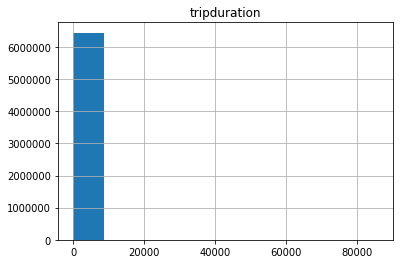

In [37]:
q2_stations.hist(column='tripduration')

In [38]:
q2_stations['tripduration'] = q2_stations['tripduration']/60

In [39]:
q2_stations = q2_stations[q2_stations['tripduration'] < 50]  

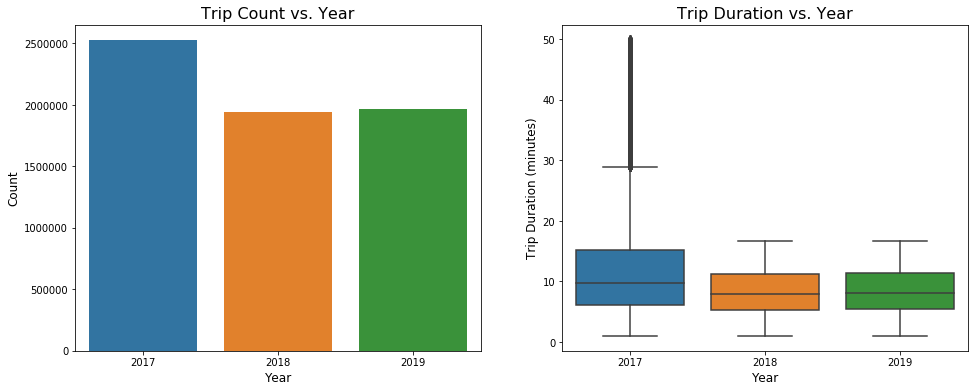

In [40]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='year', data=q2_stations, ax=ax[0])
ax[0].set_title('Trip Count vs. Year', fontsize=16)
ax[0].set_xlabel('Year', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='year', y='tripduration', data=q2_stations, ax=ax[1])
ax[1].set_title('Trip Duration vs. Year', fontsize=16)
ax[1].set_xlabel('Year', fontsize=12)
ax[1].set_ylabel('Trip Duration (minutes)', fontsize=12)
plt.show()

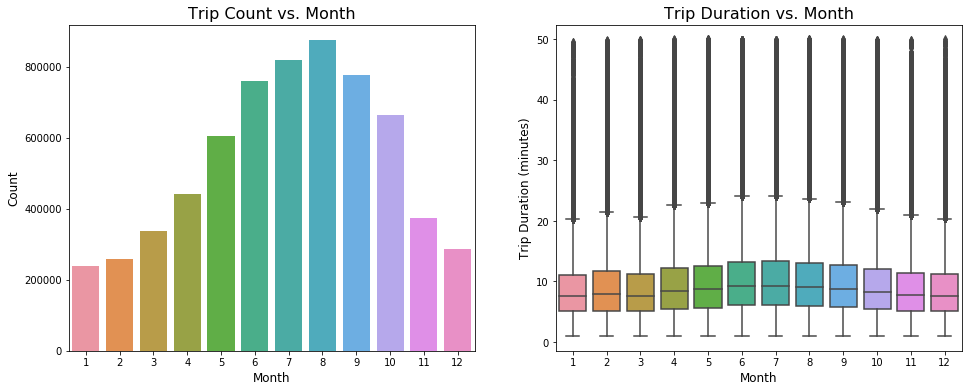

In [41]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='month', data=q2_stations, ax=ax[0])
ax[0].set_title('Trip Count vs. Month', fontsize=16)
ax[0].set_xlabel('Month', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='month', y='tripduration', data=q2_stations, ax=ax[1])
ax[1].set_title('Trip Duration vs. Month', fontsize=16)
ax[1].set_xlabel('Month', fontsize=12)
ax[1].set_ylabel('Trip Duration (minutes)', fontsize=12)
plt.show()

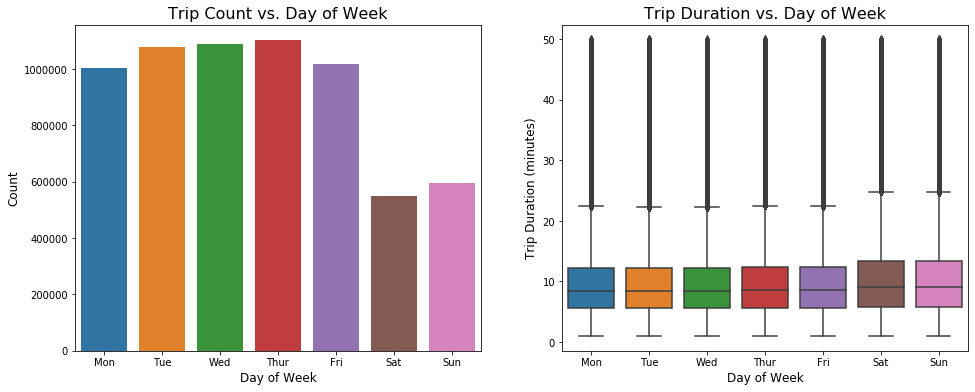

In [42]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='weekday', data=q2_stations, ax=ax[0])
ax[0].set_xticklabels(('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'))
ax[0].set_title('Trip Count vs. Day of Week', fontsize=16)
ax[0].set_xlabel('Day of Week', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='weekday', y='tripduration', data=q2_stations, ax=ax[1])
ax[1].set_title('Trip Duration vs. Day of Week', fontsize=16)
ax[1].set_xlabel('Day of Week', fontsize=12)
ax[1].set_ylabel('Trip Duration (minutes)', fontsize=12)
ax[1].set_xticklabels(('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'))
plt.show()

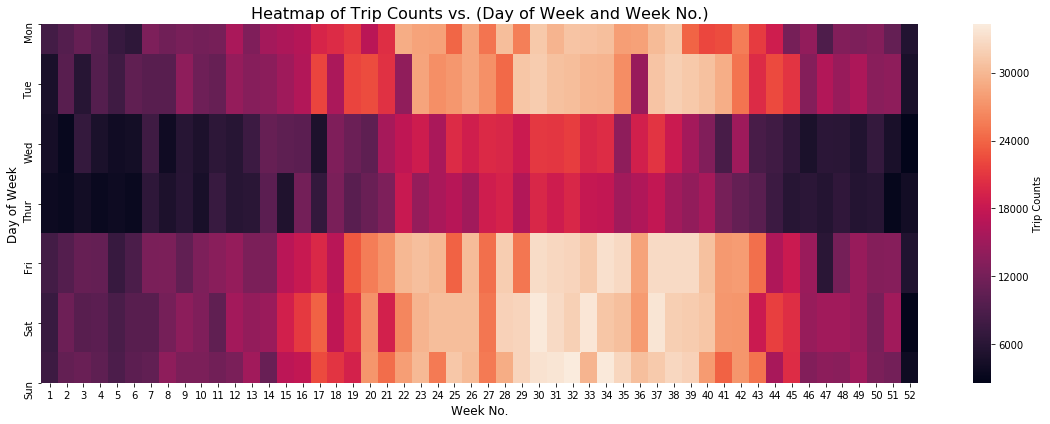

In [43]:
# heatmap of trip count vs. (weekday and week no.)
fig, ax = plt.subplots(figsize=(16, 6))
tmp = q2_stations[['weekday', 'week_number_of_year', 'tripduration']].groupby(['weekday', 'week_number_of_year']).count().reset_index()
pivots = tmp.pivot('weekday', 'week_number_of_year', 'tripduration')
sns.heatmap(pivots, cbar_kws={'label': 'Trip Counts'})
ax.set_title('Heatmap of Trip Counts vs. (Day of Week and Week No.)', fontsize=16)
ax.set_xlabel('Week No.', fontsize=12)
ax.set_ylabel('Day of Week', fontsize=12)
ax.set_yticklabels(('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'), fontsize=10)
plt.tight_layout()
plt.show()

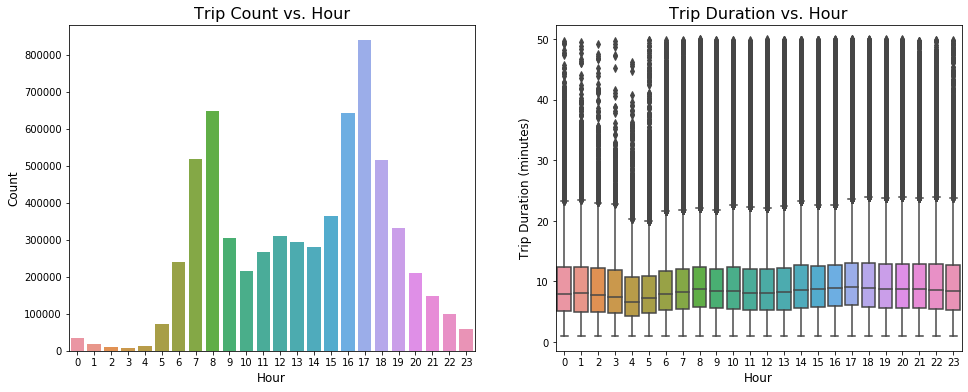

In [44]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='hour', data=q2_stations, ax=ax[0])
ax[0].set_title('Trip Count vs. Hour', fontsize=16)
ax[0].set_xlabel('Hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='hour', y='tripduration', data=q2_stations, ax=ax[1])
ax[1].set_title('Trip Duration vs. Hour', fontsize=16)
ax[1].set_xlabel('Hour', fontsize=12)
ax[1].set_ylabel('Trip Duration (minutes)', fontsize=12)
plt.show()

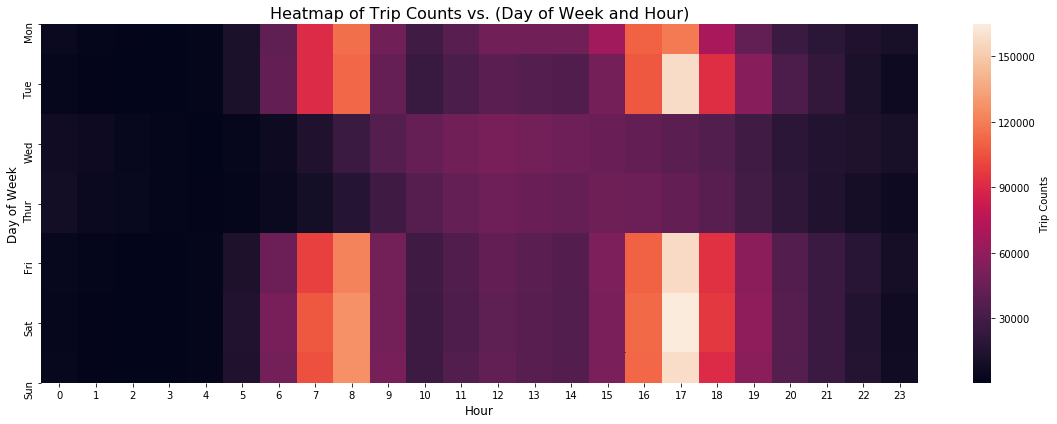

In [45]:
# heatmap of trip count vs. (day and hour)
fig, ax = plt.subplots(figsize=(16, 6))
tmp = q2_stations[['weekday', 'hour', 'tripduration']].groupby(['weekday', 'hour']).count().reset_index()
pivots = tmp.pivot('weekday', 'hour', 'tripduration')
sns.heatmap(pivots, cbar_kws={'label': 'Trip Counts'})
ax.set_title('Heatmap of Trip Counts vs. (Day of Week and Hour)', fontsize=16)
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Day of Week', fontsize=12)
ax.set_yticklabels(('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'), fontsize=10)
plt.tight_layout()
plt.show()

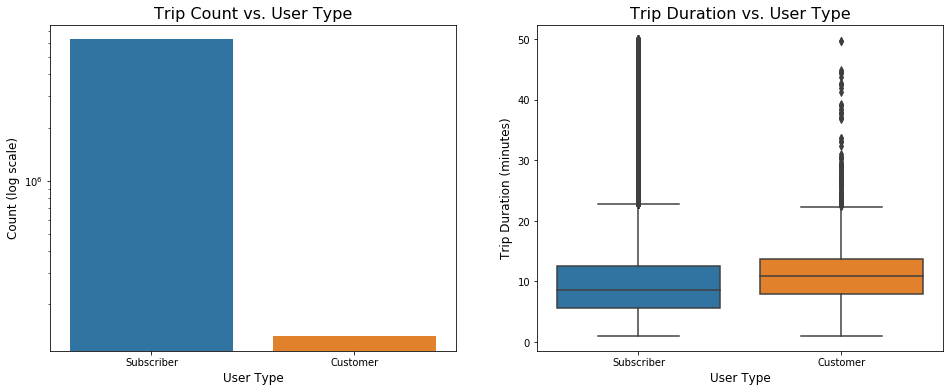

In [40]:
# Trip distribution
# Subscriber: Annual Membership
# Cumtomer: 24-hour pass
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='usertype', data=q2_stations, ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_title('Trip Count vs. User Type', fontsize=16)
ax[0].set_xlabel('User Type', fontsize=12)
ax[0].set_ylabel('Count (log scale)', fontsize=12)
sns.boxplot(x='usertype', y='tripduration', data=q2_stations, ax=ax[1])
ax[1].set_title('Trip Duration vs. User Type', fontsize=16)
ax[1].set_xlabel('User Type', fontsize=12)
ax[1].set_ylabel('Trip Duration (minutes)', fontsize=12)
plt.show()

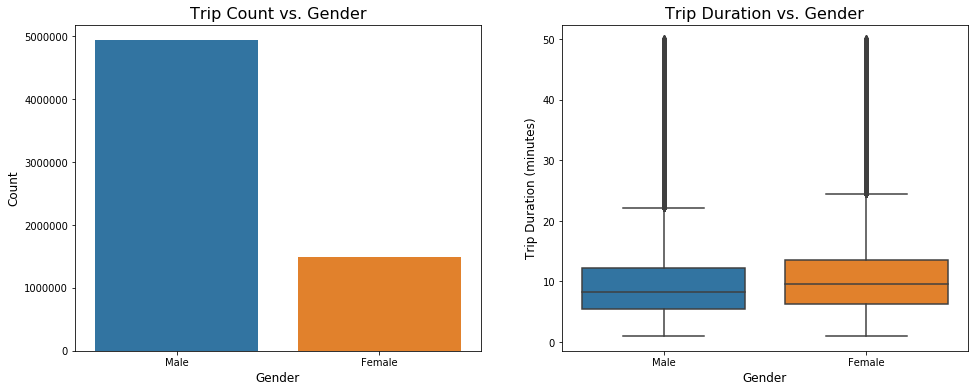

In [41]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='gender', data=q2_stations, ax=ax[0])
ax[0].set_title('Trip Count vs. Gender', fontsize=16)
ax[0].set_xlabel('Gender', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='gender', y='tripduration', data=q2_stations, ax=ax[1])
ax[1].set_title('Trip Duration vs. Gender', fontsize=16)
ax[1].set_xlabel('Gender', fontsize=12)
ax[1].set_ylabel('Trip Duration (minutes)', fontsize=12)
plt.show()

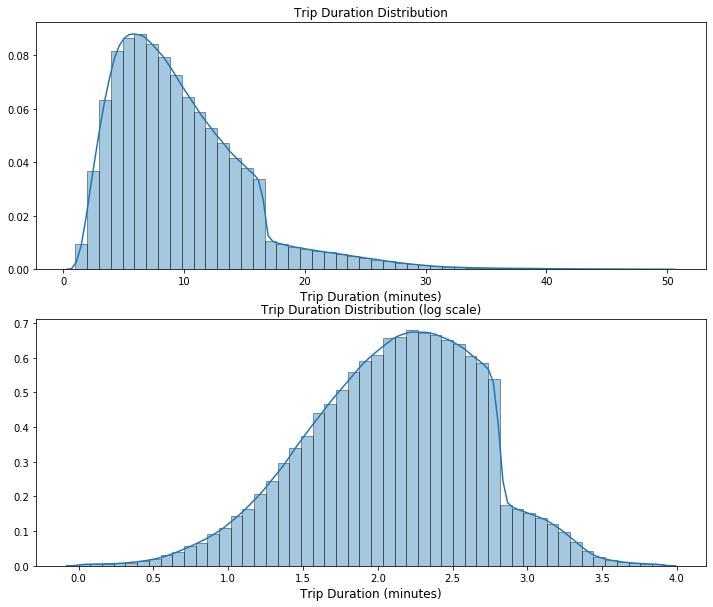

In [42]:
# Trip distribution
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
sns.distplot(q2_stations['tripduration'], ax=ax[0], 
             hist_kws={'histtype': 'bar', 'edgecolor':'black'})
ax[0].set_xlabel('Trip Duration (minutes)', fontsize=12)
ax[0].set_title('Trip Duration Distribution')

sns.distplot(np.log(q2_stations['tripduration']), ax=ax[1], 
             hist_kws={'histtype': 'bar', 'edgecolor':'black'})
ax[1].set_xlabel('Trip Duration (minutes)', fontsize=12)
ax[1].set_title('Trip Duration Distribution (log scale)')
plt.show()

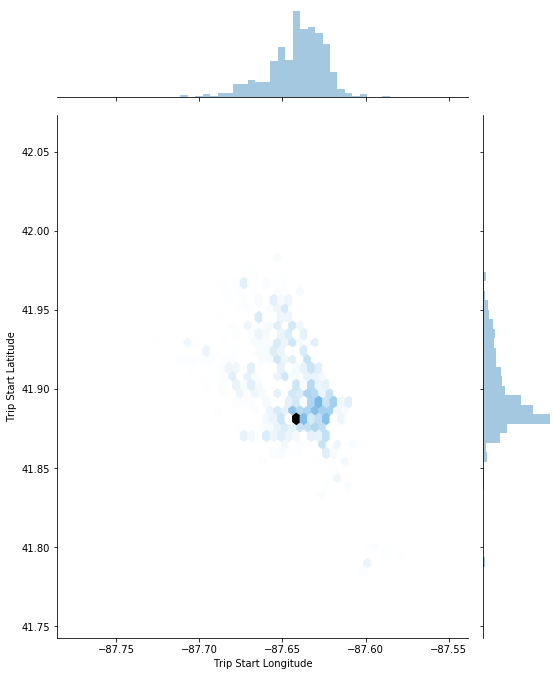

In [43]:
# trip start longitude and latitude distribution
g = sns.jointplot('from_longitude', 'from_latitude', data=q2_stations, kind='hex')
g.set_axis_labels('Trip Start Longitude', 'Trip Start Latitude')
g.fig.set_figwidth(8)
g.fig.set_figheight(10)
plt.show()

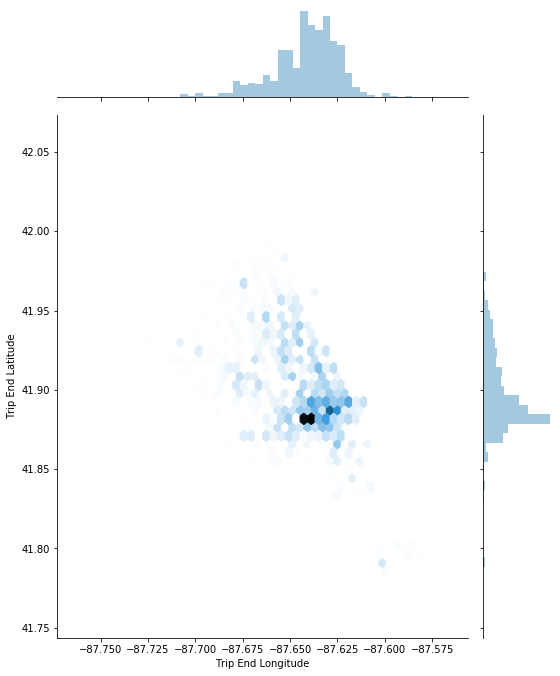

In [44]:
# trip end longitude and latitude distribution
g = sns.jointplot('to_longitude', 'to_latitude', data=q2_stations, kind='hex')
g.set_axis_labels('Trip End Longitude', 'Trip End Latitude')
g.fig.set_figwidth(8)
g.fig.set_figheight(10)
plt.show()

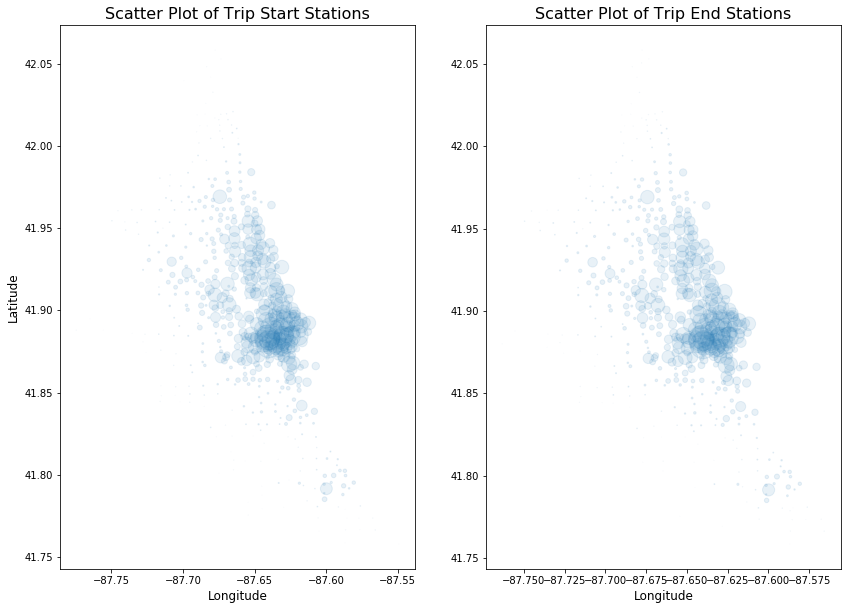

In [45]:
# group station according GPS locations
station_start = q2_stations[['from_longitude', 'from_latitude', 'tripduration']]
station_start = station_start.groupby(['from_longitude', 'from_latitude'])
station_start = station_start.count().reset_index()

station_end = q2_stations [['to_longitude', 'to_latitude', 'tripduration']]
station_end = station_end.groupby(['to_longitude', 'to_latitude'])
station_end = station_end.count().reset_index()

# visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 10))
x = station_start['from_longitude']
y = station_start['from_latitude']
s = station_start['tripduration'] / 200
ax[0].scatter(x, y, s=s, alpha=0.1)
ax[0].set_title('Scatter Plot of Trip Start Stations', fontsize=16)
ax[0].set_xlabel('Longitude', fontsize=12)
ax[0].set_ylabel('Latitude', fontsize=12)

x = station_end['to_longitude']
y = station_end['to_latitude']
s = station_end['tripduration'] / 200
ax[1].scatter(x, y, s=s, alpha=0.1)
ax[1].set_title('Scatter Plot of Trip End Stations', fontsize=16)
ax[1].set_xlabel('Longitude', fontsize=12)

plt.show()

Conclusions from above exploratory analysis

From 2017 to 2019, there are increasing demand for sharing bicycles.

Since the population of Chicago is relative constant, we can assume that people tend to live healthier as time goes on.

People use sharing bicycle more frequently in weekdays than weekends, but the average trip duration is longer in weekends than weekdays.
During rush hours (~8:00 am and ~5:00 pm), there are increasing demand for sharing bicycles during weekdays, but on weekends, there is no such clear trend.

Most users purchased the Annual Membership. But their trip durations are relatively sharter compared with ordinary customers and dependent. Those who purchased 24-hour pass tend to have longest trip.

Male users use sharing bicycle more often than female users, but female users have longer trips.

Most trips are within 15 minutes.

Most usage is in downtown Chicago. There are some stations rarely used.

In [46]:
q2_stations.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,...,from_longitude,dist_mts,revenue,trips,year,month,week,weekday,week_number_of_year,hour
0,13518905,2017-03-31 23:59:07,4/1/2017 00:13:24,5292,14.283333,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,...,-87.641823,3538.412951,1.428333,1,2017,3,13,Friday,13,23
1,13518904,2017-03-31 23:56:25,4/1/2017 00:00:21,4408,3.933333,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,Subscriber,...,-87.626761,775.740536,0.393333,1,2017,3,13,Friday,13,23
3,13518902,2017-03-31 23:54:46,3/31/2017 23:59:34,4915,4.800000,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,Subscriber,...,-87.629318,953.063652,0.480000,1,2017,3,13,Friday,13,23
4,13518901,2017-03-31 23:53:33,4/1/2017 00:00:28,4247,6.916667,327,Sheffield Ave & Webster Ave,331,Halsted St & Blackhawk St (*),Subscriber,...,-87.653818,1400.586679,0.691667,1,2017,3,13,Friday,13,23
5,13518900,2017-03-31 23:51:17,3/31/2017 23:55:19,3536,4.033333,143,Sedgwick St & Webster Ave,289,Wells St & Concord Ln,Subscriber,...,-87.638888,1168.482536,0.403333,1,2017,3,13,Friday,13,23


train period: between 2017/01/01 and 2018/12/31
test period: between 2019/01/01 and 2019/12/

In [46]:
split_date = pd.datetime(2018,12,31)
df_train = q2_stations.loc[q2_stations['start_time'] <= split_date]
df_train['trips_per_day'] = df_train.trips / 365
df_test = q2_stations.loc[q2_stations['start_time'] > split_date]
df_test['trips_per_day'] = df_test.trips / 365

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [96]:
q2_stations.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,...,from_longitude,dist_mts,revenue,trips,year,month,week,weekday,week_number_of_year,hour
0,13518905,2017-03-31 23:59:07,4/1/2017 00:13:24,5292,14.283333,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,...,-87.641823,3538.412951,1.428333,1,2017,3,13,Friday,13,23
1,13518904,2017-03-31 23:56:25,4/1/2017 00:00:21,4408,3.933333,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,Subscriber,...,-87.626761,775.740536,0.393333,1,2017,3,13,Friday,13,23
3,13518902,2017-03-31 23:54:46,3/31/2017 23:59:34,4915,4.800000,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,Subscriber,...,-87.629318,953.063652,0.480000,1,2017,3,13,Friday,13,23
4,13518901,2017-03-31 23:53:33,4/1/2017 00:00:28,4247,6.916667,327,Sheffield Ave & Webster Ave,331,Halsted St & Blackhawk St (*),Subscriber,...,-87.653818,1400.586679,0.691667,1,2017,3,13,Friday,13,23
5,13518900,2017-03-31 23:51:17,3/31/2017 23:55:19,3536,4.033333,143,Sedgwick St & Webster Ave,289,Wells St & Concord Ln,Subscriber,...,-87.638888,1168.482536,0.403333,1,2017,3,13,Friday,13,23


In [47]:
INDICATOR = 'total_docks'
features = ['tripduration', 'to_station_id','to_longitude','from_longitude','revenue']
X_train = df_train[features]
y_train = df_train[INDICATOR]
X_test = df_test[features]
y_test = df_test[INDICATOR]

In [78]:
# extract the predictors and target data.
predictors = q2_stations[['tripduration', 'to_station_id','to_longitude','from_longitude','revenue']]
target = q2_stations['total_docks']

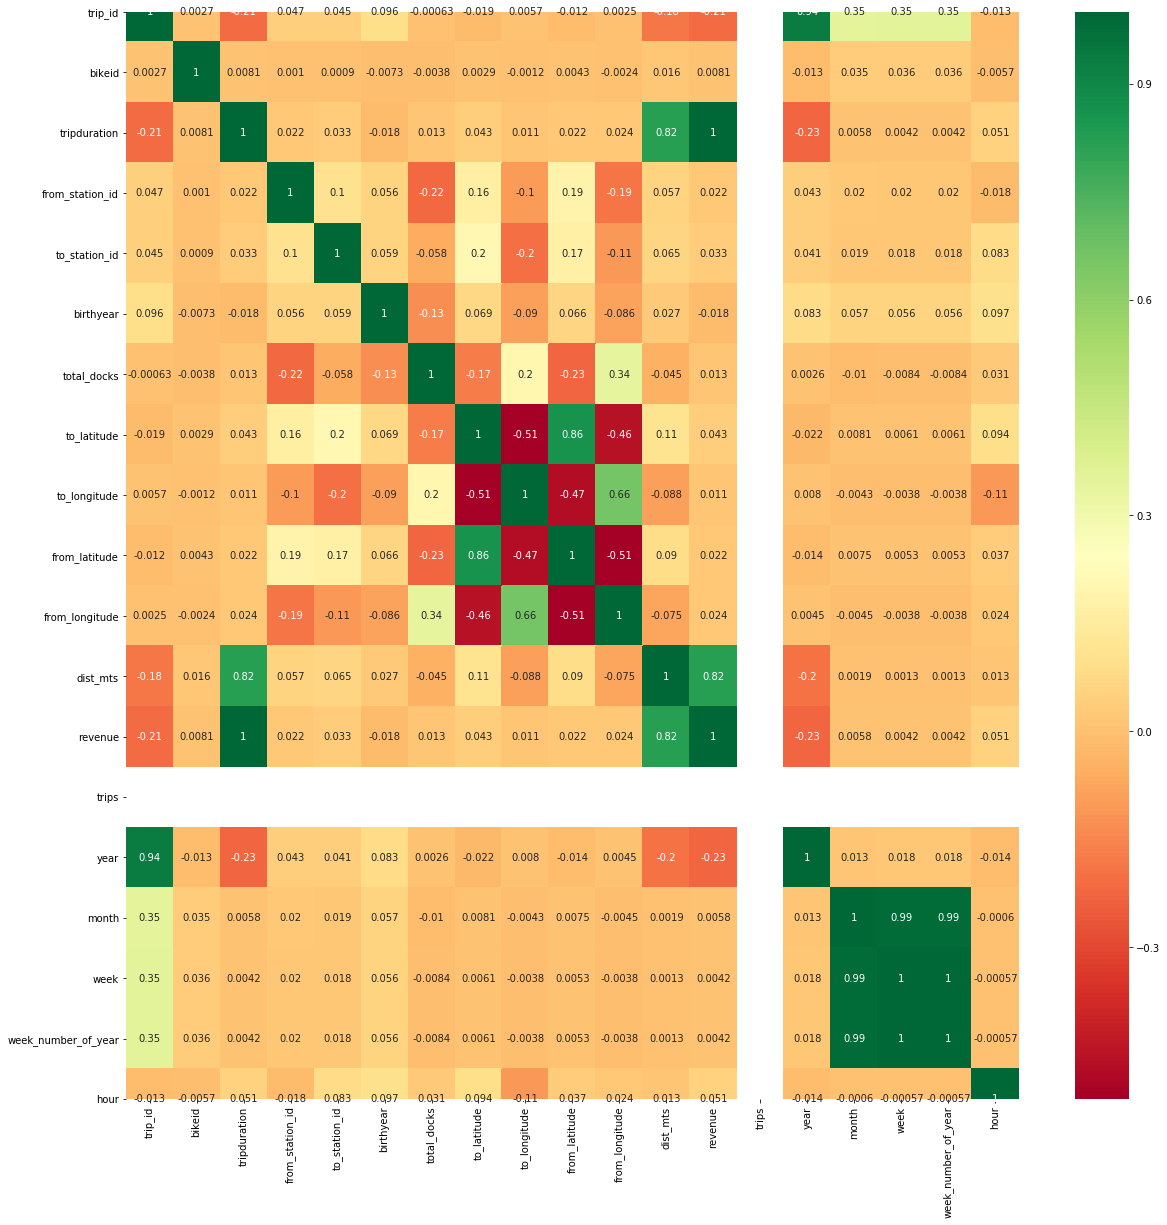

In [50]:
#get correlations of each features in dataset
corrmat = q2_stations.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(q2_stations[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [51]:
model = KNeighborsRegressor(n_neighbors=2, weights='distance')
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='distance')

In [53]:
#import the KNeighborsClassifier class from sklearn
from sklearn.neighbors import KNeighborsClassifier

#import metrics model to check the accuracy 
from sklearn import metrics
#Try running from k=1 through 25 and record testing accuracy
k_range = range(1,2)
scores = {}
scores_list = []
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train,y_train)
        y_pred=knn.predict(X_test)
        scores[k] = metrics.accuracy_score(y_test,y_pred)
        scores_list.append(metrics.accuracy_score(y_test,y_pred))

In [54]:
scores

{1: 0.6323243636770923}

In [55]:
pred = knn.predict(X_test)

In [92]:
df_test["predicted_docks"] = pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [97]:
#Difference between existing and predicted docs

df_test["dock_diff"] = df_test["total_docks"] - df_test["predicted_docks"]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [122]:
df_test['abs_dock_diff'] = df_test['dock_diff'].abs()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [124]:
df_test1 = df_test.sort_values('abs_dock_diff', ascending=False).drop_duplicates(['from_station_id'])

In [127]:
#Assuming each dock setup in a station costs $350
m = df_test1.groupby(['from_station_id']).agg({'dock_diff':sum})

In [117]:
table = pd.pivot_table(df_test, index =['from_station_id', 'dock_diff']) 

In [129]:
#Cost of setting up all the extra docks assuming each single dock costs company $400

m['cost'] = m['dock_diff']*400

In [135]:
total = m['cost'].sum()
total

-3640400.0

#From above it can be condluded that for 2019 alone

In [130]:
m.head()

,dock_diff,cost
from_station_id,,
2,28.0,11200.0
3,44.0,17600.0
4,-32.0,-12800.0
5,-32.0,-12800.0
6,28.0,11200.0


In [115]:
n= [l,m]
result = pd.concat(n)
result.tail()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,dock_diff,revenue
from_station_id,,
660,-24.0,NaN
664,-39.0,NaN
666,-1360.0,NaN
672,-42908.0,NaN
673,5644.0,NaN


Evaluation of classification quality

In [59]:
from sklearn.metrics import classification_report,confusion_matrix
conf_mat=confusion_matrix(y_test,pred)
print(conf_mat)

[[     0      0      0      2      0      3      3      0      0      0
       0      0      0      0]
 [     0  11578      0   6151      3   3170   2541   2760   2322   4034
    1372     90     93    374]
 [     2      4    105    711      1   2214    288     37      7      9
       0      6      1      0]
 [     4   3318     55 219529     87  48964  28077  18509  12439   6924
    6412   1911   2712   1845]
 [     0    272      0   1183    169    854   1006    214     36     59
       0      0      1      0]
 [     4   1584     49  44744     36 262564  36465  21350  20041   7103
   13924   5250   3905   1254]
 [     2   1268      4  24938     34  35668 173634  14301  14432   8729
    4937   4306   7842    350]
 [     0   1199      2  15738      5  20648  14820 139824  14677   6665
    6722   1262   3366    159]
 [     0   1120      0  12479      1  17128  12334  11958 183983   6399
    7894    870   4233   1242]
 [     0    198      0   5954      1   6096   4471   4274   4814  65660
 

In [60]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         7.0       0.00      0.00      0.00         8
        11.0       0.54      0.34      0.41     34488
        12.0       0.49      0.03      0.06      3385
        15.0       0.64      0.63      0.63    350786
        16.0       0.50      0.04      0.08      3794
        19.0       0.62      0.63      0.63    418273
        23.0       0.60      0.60      0.60    290445
        27.0       0.63      0.62      0.63    225087
        31.0       0.69      0.71      0.70    259641
        35.0       0.57      0.66      0.61     99884
        39.0       0.61      0.62      0.61    120799
        43.0       0.62      0.63      0.63     44137
        47.0       0.67      0.74      0.71     80973
        55.0       0.75      0.69      0.72     32515

    accuracy                           0.63   1964215
   macro avg       0.57      0.50      0.50   1964215
weighted avg       0.63      0.63      0.63   1964215



In [61]:
print("Misclassification error rate:",round(np.mean(pred!=y_test),3))

Misclassification error rate: 0.368


Choosing 'k' by elbow method

In [62]:
error_rate = []

# Will take some time
for i in range(1,20):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error (misclassification) Rate')

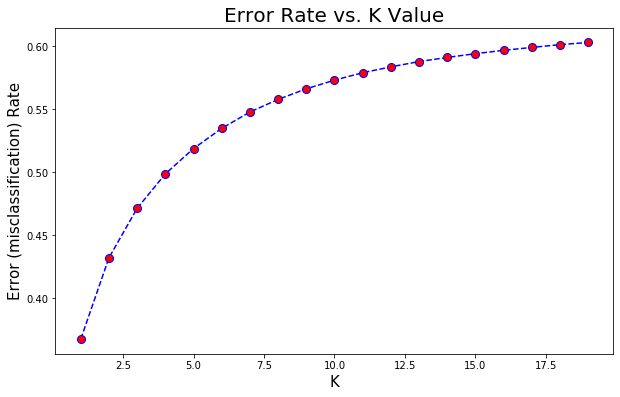

In [63]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. K Value', fontsize=20)
plt.xlabel('K',fontsize=15)
plt.ylabel('Error (misclassification) Rate',fontsize=15)

Using LogisticRegression estimator from Scikit-learn

In [64]:
clf1 = LogisticRegression(penalty='l2',solver='newton-cg')

In [65]:
clf1.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
clf1.intercept_

array([ -717.79296054, -1052.40638154,  -562.8225839 , -2582.09122193,
       -1534.72106364,  -500.14729246,  -839.79730662,   -98.77032261,
        2763.58905452,   404.85824997,  5153.78006594,  2513.28106528,
         881.9613725 ,  4316.99775295])

In [67]:
clf1.coef_

array([[ 1.52004620e-01, -3.35084814e-03, -1.29692732e+00,
        -6.75672772e+00,  1.52004620e-02],
       [ 6.07914236e-02,  6.57454770e-04,  2.02108952e+01,
        -3.21643759e+01, -3.79689422e-01],
       [-4.64252664e-02, -4.75939829e-03, -6.00993136e-01,
        -5.72547463e+00, -4.64252661e-03],
       [-2.82655061e-02,  1.50603829e-04,  6.95939698e+00,
        -3.64020091e+01,  3.83095334e-01],
       [ 1.40594701e-02, -3.34293667e-03, -5.37186378e+00,
        -1.20370775e+01,  1.49910922e-03],
       [-1.41000246e-02,  6.03845331e-04, -1.30192977e+00,
        -4.38978851e+00,  8.10877878e-02],
       [ 2.54135669e-03,  7.46021208e-05, -7.77479125e-01,
        -8.78430540e+00, -2.73922355e-02],
       [-3.56816535e-02,  5.72893774e-05, -5.34549379e+00,
         4.23897754e+00, -1.90378978e-02],
       [ 3.99769447e-02, -8.03926719e-04, -2.86790552e-01,
         3.18407236e+01, -4.22165036e-01],
       [-1.19939232e-02, -1.19624624e-04,  4.29015279e+00,
         3.60679857e-01

In [68]:
clf1.score(X_test,y_test)

0.22214930646594186

For LogisticRegression estimator, there is a special predict_proba method which computes the raw probability values

Naive Bayes Classification

In [87]:
nbc = GaussianNB()

In [88]:
nbc.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [89]:
y_pred = nbc.predict(X_test)
mislabel = np.sum((y_test!=y_pred))
print("Total number of mislabelled data points from {} test samples is {}".format(len(y_test),mislabel))

Total number of mislabelled data points from 1964215 test samples is 1520611


In [90]:
from sklearn.metrics import classification_report

In [91]:
print("The classification report is as follows...\n")
print(classification_report(y_pred,y_test))

The classification report is as follows...



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

         7.0       0.00      0.00      0.00         0
        11.0       0.01      0.04      0.01      5289
        12.0       0.00      0.00      0.00         0
        15.0       0.27      0.33      0.30    288666
        16.0       0.00      0.00      0.00         0
        19.0       0.38      0.25      0.30    622746
        23.0       0.00      0.00      0.00         0
        27.0       0.06      0.15      0.08     85150
        31.0       0.60      0.18      0.28    844638
        35.0       0.00      0.00      0.00      8258
        39.0       0.07      0.15      0.09     56854
        43.0       0.00      0.00      0.00         0
        47.0       0.00      0.27      0.00        37
        55.0       0.45      0.28      0.34     52577

    accuracy                           0.23   1964215
   macro avg       0.13      0.12      0.10   1964215
weighted avg       0.43      0.23      0.28   1964215



In [70]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [73]:
y_pred = rf_reg.predict(X_test)

In [75]:
rsqure_score = rf_reg.score(X_train,y_train)
print('R^2: {}'.format(rsqure_score))

R^2: 0.9993998350626584


In [82]:
from sklearn.model_selection import cross_val_score, cross_val_predict

Perform the training using KFolds cross validation method

In [83]:
cv_r2_scores_rf = cross_val_score(rf_reg, predictors, target, cv=5,scoring='r2')
print(cv_r2_scores_rf)
print("Mean 5-Fold R Squared: {}".format(np.mean(cv_r2_scores_rf)))

[0.99760784 0.99769269 0.99812629 0.99863175 0.99752355]
Mean 5-Fold R Squared: 0.9979164234303518


In [18]:
df.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,total_docks,to_latitude,to_longitude,from_latitude,from_longitude
0,13518905,3/31/2017 23:59:07,4/1/2017 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0,23.0,41.855136,-87.654127,41.885637,-87.641823
1,13518904,3/31/2017 23:56:25,4/1/2017 00:00:21,4408,236,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,Subscriber,Male,1990.0,31.0,41.890359,-87.617532,41.891466,-87.626761
2,13518903,3/31/2017 23:55:33,4/1/2017 00:01:21,696,348,520,Greenview Ave & Jarvis Ave,432,Clark St & Lunt Ave,Subscriber,Female,1979.0,19.0,42.009074,-87.674190,42.015962,-87.668570
3,13518902,3/31/2017 23:54:46,3/31/2017 23:59:34,4915,288,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,Subscriber,Male,1985.0,27.0,41.894503,-87.617854,41.893992,-87.629318
4,13518901,3/31/2017 23:53:33,4/1/2017 00:00:28,4247,415,327,Sheffield Ave & Webster Ave,331,Halsted St & Blackhawk St (*),Subscriber,Female,1989.0,19.0,41.909668,-87.648128,41.921540,-87.653818


In [48]:
df['year'] = pd.DatetimeIndex(df['start_time']).year

In [49]:
df['age'] = df['year'] - df['birthyear']

In [67]:
X_train.head()

,tripduration,total_docks,dist_mts,revenue
0,857.0,23.0,3538.412951,1.428333
1,236.0,31.0,775.740536,0.393333
2,348.0,19.0,895.576411,0.580000
3,288.0,27.0,953.063652,0.480000
4,415.0,19.0,1400.586679,0.691667


In [74]:
notnans = df.age.notnull()

In [76]:
notnans.shape

(11250100,)

In [96]:
df.dtypes

trip_id                int64
start_time            object
end_time              object
bikeid                 int64
tripduration         float64
from_station_id        int64
from_station_name     object
to_station_id          int64
to_station_name       object
usertype              object
gender                object
birthyear            float64
total_docks          float64
to_latitude          float64
to_longitude         float64
from_latitude        float64
from_longitude       float64
dist_mts             float64
revenue              float64
year                   int64
age                  float64
dtype: object

In [86]:
X_train = df[notnans]

In [90]:
X_train = X_train[['tripduration', 'total_docks','dist_mts','revenue']]

In [100]:
X_test = df.loc[~notnans].copy()

In [104]:
X_test = X_test[['tripduration', 'total_docks','dist_mts','revenue']]

In [101]:
y_test = X_test['age']

In [89]:
y_train = X_train['age']

In [103]:
# drop all rows with any NaN and NaT values
X_test = X_test.dropna()

In [93]:
nbc.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [107]:
clf1.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the numb

KeyboardInterrupt: 

In [98]:
# drop all rows with any NaN and NaT values
df_train1 = df_train1.dropna()

ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required.

In [83]:
df_test1 = df[df.age.isnull()]

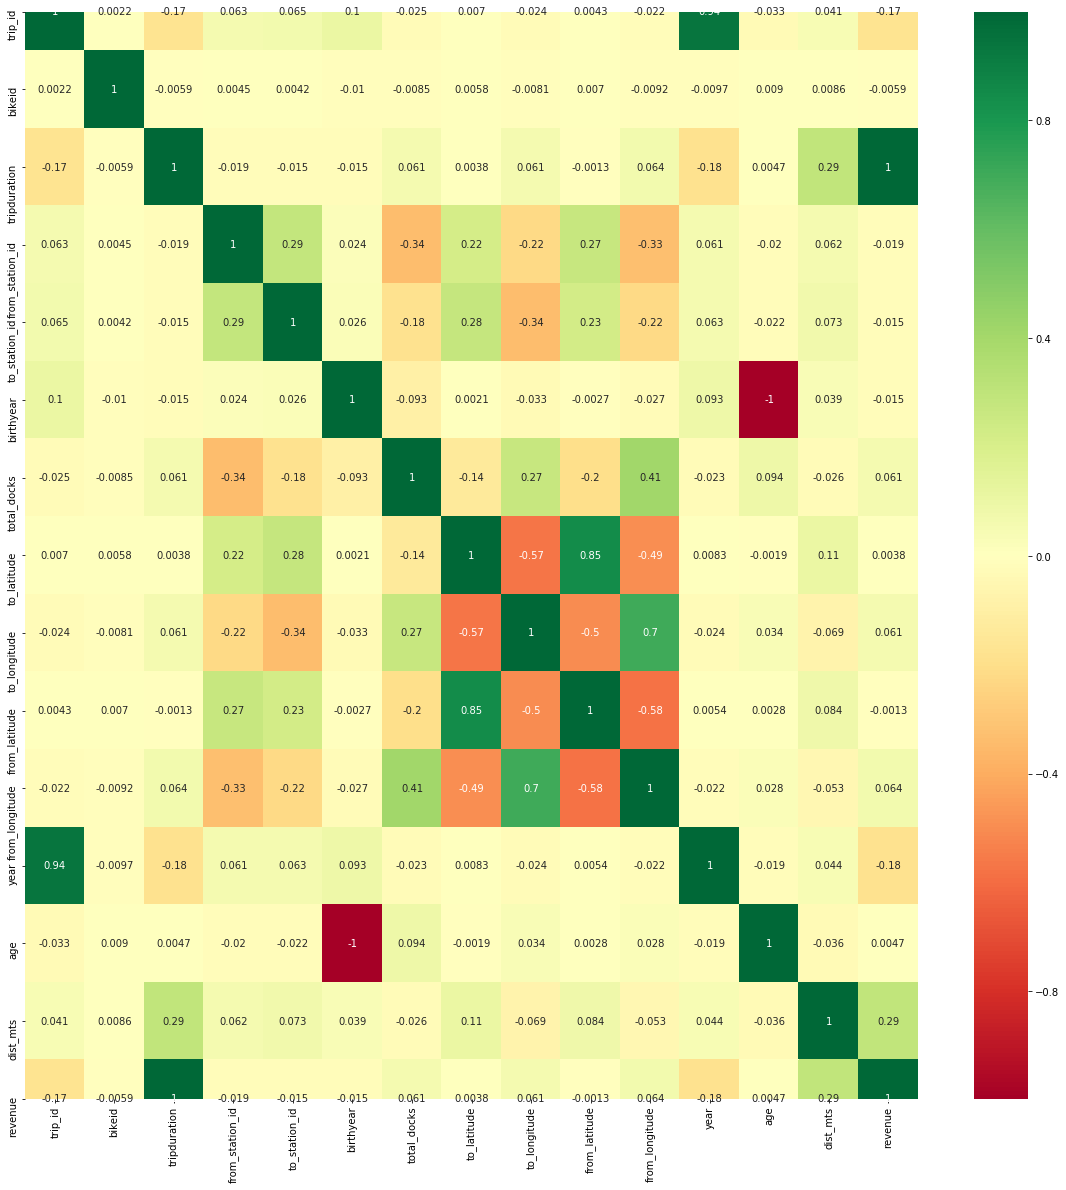

In [80]:
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")